# Comparison of casualties in double lane road and settled single lane

In [17]:
import pandas as pd
import numpy as np
from siuba import *
from plotnine import *

# Road data (junction information and segment of interest)

In [12]:
df_junctions = pd.DataFrame({
    'name': ['Eilot',
        'Meches', 'Beer Ora', 'Timna', 'Samar', 'Yotvata', 'Grofit', 'Ktora', 'Yahel', 'Menuha', 'Paran',
        'Tsukim', 'Tzofar', 'Sapir', 'Ein Yahav', 'Hazeva', 'Idan', 'Haarava Junc'
        ],
    'location':[
        11.9, 15.6, 27, 36, 41.3, 49.5, 54, 60.4, 72.3, 97.6, 105.9, 120.4, 128.9, 134.8, 138.6, 153.4, 158.2, 180.5]
})

loc_dict = dict(zip(df_junctions.name, df_junctions.location))

In [13]:
# Parameters along road 90 for our analysis
# Numbers taken from: https://he.wikipedia.org/wiki/%D7%9B%D7%91%D7%99%D7%A9_90#%D7%A6%D7%9E%D7%AA%D7%99%D7%9D_%D7%95%D7%9E%D7%97%D7%9C%D7%A4%D7%99%D7%9D_%D7%9C%D7%90%D7%95%D7%A8%D7%9A_%D7%94%D7%9B%D7%91%D7%99%D7%A9
double_lane = [loc_dict['Eilot'], loc_dict['Ktora']]   # From Eilot junction to Ktora Junction
single_lane = [loc_dict['Paran'], loc_dict['Idan']]  # Till Arava Junction

length_single_lane = single_lane[1] - single_lane[0]
length_double_lane = double_lane[1] - double_lane[0]

# Load casualties and clean

In [26]:
df_casualties = pd.read_excel("../data/casualties_in_accidents/file_5c6cf05f-2fa2-4ffb-b06a-a721caca2d1e_more_years_real.xlsx",
    header=22, usecols="A:F", names=['year', 'location', 'total', 'killed', 'severe_injury', 'light_injury'])

total_str = df_casualties.iloc[0, 0]
unknown_str = df_casualties.iloc[0, 1]
df_casualties = (
    df_casualties
    .replace(total_str, np.nan)
    .replace(unknown_str, np.nan)
    .dropna(how='any', axis=0, subset=['location', 'year'])
    .fillna(0)
)
df_casualties.location = df_casualties.location.str.replace(".x", ".0")
df_casualties.location = df_casualties.location.astype(float)
df_casualties = (
    df_casualties 
    >> mutate(place = if_else((_.location >= single_lane[0]) & (_.location <= single_lane[1]), 
        'single lane', if_else((_.location >= double_lane[0]) & (_.location <= double_lane[1]), 'double lane', 'other')))
    >> mutate(before=_.year < 2012)
    >> filter(_.place != 'other')
)
df_casualties

/tmp/ipykernel_705972/3360713564.py:13: FutureWarning: The default value of regex will change from True to False in a future version.


,year,location,total,killed,severe_injury,light_injury,place,before
820,2003.0,14.6,4,0.0,0.0,4.0,double lane,True
821,2003.0,16.5,4,0.0,0.0,4.0,double lane,True
822,2003.0,24.3,11,0.0,0.0,11.0,double lane,True
823,2003.0,39.9,4,0.0,0.0,4.0,double lane,True
824,2003.0,43.0,27,1.0,4.0,22.0,double lane,True
...,...,...,...,...,...,...,...,...
2225,2021.0,119.5,13,1.0,2.0,10.0,single lane,False
2226,2021.0,129.4,4,0.0,1.0,3.0,single lane,False
2227,2021.0,129.8,4,0.0,0.0,4.0,single lane,False
2228,2021.0,131.0,3,0.0,3.0,0.0,single lane,False


# Plot time series

In [49]:
metric = 'total'

In [50]:
freqs = (
    df_casualties
    >> group_by(_.place, _.before)
    >> summarize(total_mean=_[metric].sum() / (_.year.nunique()))
    >> mutate(total_mean=_.total_mean / if_else(_.place=='single lane', length_single_lane, length_double_lane))
    >> mutate(xstart=if_else(_.place=='single lane', single_lane[0], double_lane[0]))
    >> mutate(xend=if_else(_.place=='single lane', single_lane[1], double_lane[1]))
    >> mutate(two_way=if_else(_.before, 'Before 2012', 'After 2012'))
)


freqs

,place,before,total_mean,xstart,xend,two_way
0,double lane,False,0.286598,11.9,60.4,After 2012
1,double lane,True,0.836197,11.9,60.4,Before 2012
2,single lane,False,0.308052,105.9,158.2,After 2012
3,single lane,True,0.416401,105.9,158.2,Before 2012


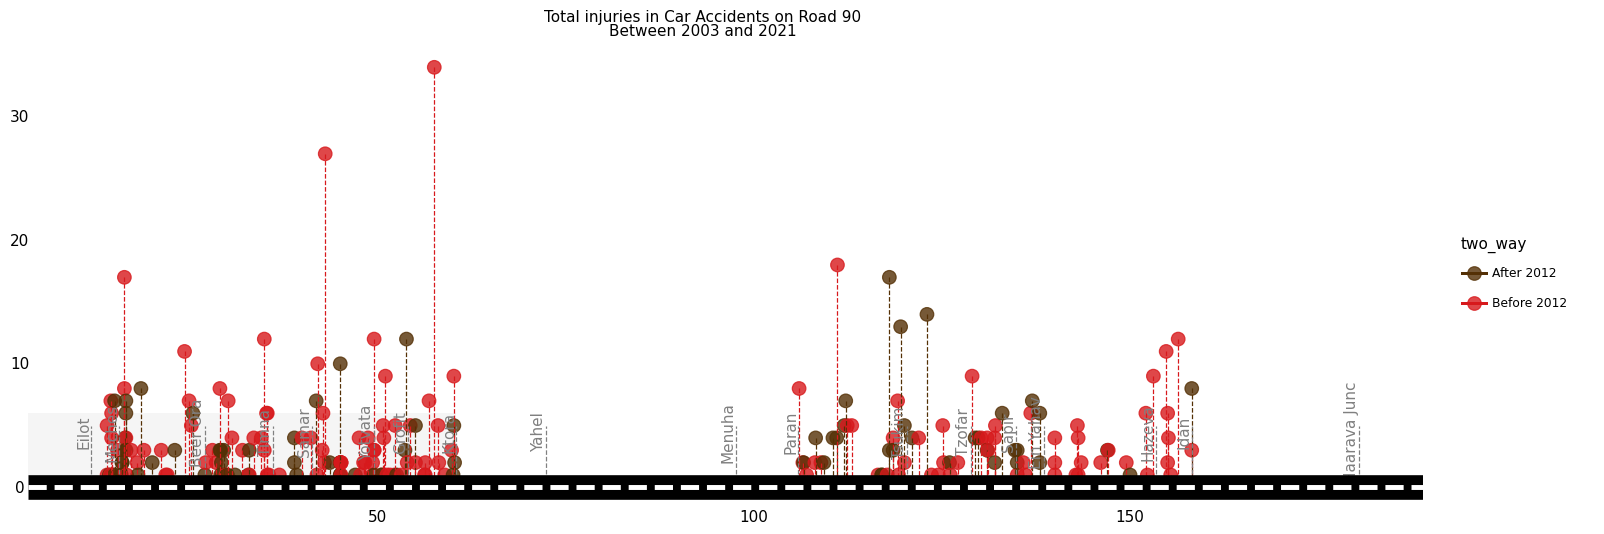

<ggplot: (8741908716114)>

In [51]:

color_dict = {
    'Before 2012': '#d7191c',
    'After 2012': '#543005'
}
height_base=10
(
    df_casualties
    # Filter to only include locations of interest
    >> filter()
    >> group_by(_.location, _.year, _.before)
    # >> filter(_.year > 2012)
    >> summarize(total=_.total.sum(), killed=_.killed.sum(), severe_injury=_.severe_injury.sum(), light_injury=_.light_injury.sum() )
    >> mutate(two_way=if_else(_.before, 'Before 2012', 'After 2012'))
    >> (
        ggplot(aes(x='location', y=metric))
        # One / two way roads
        + geom_rect(xmin=0, xmax=double_lane[1], ymin=0, ymax=6, alpha=1, fill='#F5F5F5')

        # Casualties
        + geom_point(aes(color='two_way'), size=5,  alpha=.8) # + scale_color_identity()
        + geom_segment(aes(xend='location', color='two_way'), yend=0, linetype='dashed')

        + scale_color_manual(color_dict)

        # Casualties per year per place
        + geom_segment(aes(x='xstart', xend='xend', y='total_mean', yend='total_mean', color='two_way'), freqs)

        # Junctions
        + geom_segment(aes(x='location', xend='location'), df_junctions, 
                y=0, yend=height_base-5, linetype='dashed', color='gray')
        + geom_text(aes(x='location', label='name', y='4.5'), df_junctions, angle=90, ha='right', color='gray')


        # "Road"
        + geom_hline(yintercept=0, size=10)
        + geom_hline(yintercept=0, size=2, color='white', linetype='dashed')
        # + ylim(0, 6)
        + theme_void()
        + theme(
            figure_size=(18, 6),
            axis_text_x=element_text(),
            axis_text_y=element_text(),
            axis_ticks_major=element_line(size=1)
            
            # axis_line_y=element_line(size=1, color='red')
        )
        + ggtitle("Total injuries in Car Accidents on Road 90\nBetween 2003 and 2021")
    )
)